In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import zipfile
import os

def extract_zip_with_progress(zip_file_path, extracted_dir):
    if not os.path.exists(zip_file_path):
        print("Zip file not found. Please check the path.")
        return

    if not os.path.exists(extracted_dir):
        os.makedirs(extracted_dir)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        total_files = len(zip_ref.namelist())

        extracted_files = 0
        for idx, file in enumerate(zip_ref.namelist()):
            zip_ref.extract(file, extracted_dir)
            extracted_files += 1

            progress = (extracted_files / total_files) * 100
            print(f"\rExtracting... {progress:.2f}% complete", end='', flush=True)

    print("\nExtraction complete.")

zip_file_path = "/content/drive/MyDrive/pheme-rnr-dataset.zip"
extracted_dir = "/content/dataset"

extract_zip_with_progress(zip_file_path, extracted_dir)


Extracting... 100.00% complete
Extraction complete.


In [22]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

print(stop_words)


{'once', 't', 'more', 'other', 'hadn', 'wasn', 'will', 'each', 'ma', "mustn't", "you're", "that'll", 'wouldn', 'but', 'now', 'how', 'shouldn', 'didn', 'these', 'who', 'of', 'were', 'those', 'it', 'during', 'should', 'where', 'had', "you'll", 'while', 'own', "shan't", 'so', 'does', 'haven', 'its', "you'd", "won't", "you've", 'their', 'having', 'itself', 'm', 'because', 'most', 'below', 'is', 'himself', 'be', 'o', 'yourselves', 'just', "shouldn't", 'theirs', 'needn', 'no', 'down', 'out', 'aren', 'through', 'all', "doesn't", 'isn', 'off', 'him', 'the', 'some', 'why', 'not', 'only', 's', 'whom', 'we', "haven't", 'yourself', 'won', 'her', 'nor', 'ours', 'before', 'themselves', 'hers', "mightn't", 'between', "hadn't", 'they', 'she', 'doesn', 'as', 'here', 'any', 'ain', 'his', 'again', 'did', 'our', "should've", "she's", 'what', 'that', "aren't", 'until', 'been', 'doing', 'over', 'and', 'a', 'shan', 'i', 'both', 'being', 'mustn', 'he', 'on', 've', 'me', 'up', "didn't", 'hasn', 'into', "needn'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
import json
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import pickle
import nltk

nltk.download('punkt')


def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

data = []
labels = []
rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    rumour_files = os.listdir(rumour_path)
    for file in rumour_files:
        with open(os.path.join(rumour_path, file, "source-tweet", file + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)

    non_rumour_files = os.listdir(non_rumour_path)
    for file in non_rumour_files:
        with open(os.path.join(non_rumour_path, file, "source-tweet", file + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

print("Naive Bias Classifcation Report: ")
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred, target_names=['Non-rumour', 'Rumour'])
print("Classification Report:")
print(report)

with open('multinomial_nb_model.pkl', 'wb') as f:
    pickle.dump(model, f)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Naive Bias Classifcation Report: 
Accuracy: 0.8570198105081827
Classification Report:
              precision    recall  f1-score   support

  Non-rumour       0.86      0.93      0.90       764
      Rumour       0.85      0.71      0.77       397

    accuracy                           0.86      1161
   macro avg       0.85      0.82      0.83      1161
weighted avg       0.86      0.86      0.85      1161



In [19]:
import json
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import pickle

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

data = []
labels = []
rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    rumour_files = os.listdir(rumour_path)
    for file in rumour_files:
        with open(os.path.join(rumour_path, file, "source-tweet", file + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)
    non_rumour_files = os.listdir(non_rumour_path)
    for file in non_rumour_files:
        with open(os.path.join(non_rumour_path, file, "source-tweet", file + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train_tfidf, y_train)

print("Random Forest Classifcation Report: ")
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred, target_names=['Non-rumour', 'Rumour'])
print("Classification Report:")
print(report)

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Random Forest Classifcation Report: 
Accuracy: 0.8647717484926787
Classification Report:
              precision    recall  f1-score   support

  Non-rumour       0.89      0.91      0.90       764
      Rumour       0.81      0.79      0.80       397

    accuracy                           0.86      1161
   macro avg       0.85      0.85      0.85      1161
weighted avg       0.86      0.86      0.86      1161



In [21]:
import json
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import pickle

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

data = []
labels = []
rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    rumour_files = os.listdir(rumour_path)
    for file in rumour_files:
        with open(os.path.join(rumour_path, file, "source-tweet", file + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)

    non_rumour_files = os.listdir(non_rumour_path)
    for file in non_rumour_files:
        with open(os.path.join(non_rumour_path, file, "source-tweet", file + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = SVC()
model.fit(X_train_tfidf, y_train)
print("SVM Classifcation Report: ")
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred, target_names=['Non-rumour', 'Rumour'])
print("Classification Report:")
print(report)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(model, f)


SVM Classifcation Report: 
Accuracy: 0.8716623600344531
Classification Report:
              precision    recall  f1-score   support

  Non-rumour       0.88      0.93      0.91       764
      Rumour       0.86      0.75      0.80       397

    accuracy                           0.87      1161
   macro avg       0.87      0.84      0.85      1161
weighted avg       0.87      0.87      0.87      1161



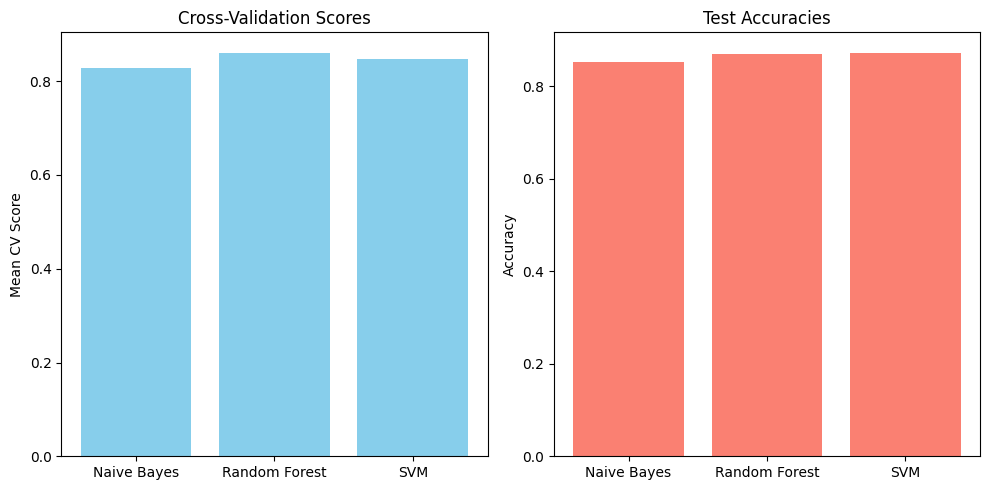

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os

rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

data = []
labels = []

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    for file_name in os.listdir(rumour_path):
        with open(os.path.join(rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)

    for file_name in os.listdir(non_rumour_path):
        with open(os.path.join(non_rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)
df = pd.DataFrame({'Text': data, 'Label': labels})

if 'Text' not in df.columns:
    print("The 'Text' column does not exist in the DataFrame.")
    raise KeyError("Column 'Text' not found.")

if df.empty:
    print("DataFrame is empty. Please check the loaded data.")
    raise ValueError("DataFrame is empty.")

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_vectorized, y_train)

svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train_vectorized, y_train)

nb_cv_scores = cross_val_score(nb_classifier, X_train_vectorized, y_train, cv=5)
rf_cv_scores = cross_val_score(rf_classifier, X_train_vectorized, y_train, cv=5)
svm_cv_scores = cross_val_score(svm_classifier, X_train_vectorized, y_train, cv=5)

nb_test_accuracy = accuracy_score(y_test, nb_classifier.predict(X_test_vectorized))
rf_test_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test_vectorized))
svm_test_accuracy = accuracy_score(y_test, svm_classifier.predict(X_test_vectorized))

models = ['Naive Bayes', 'Random Forest', 'SVM']
cv_scores = [nb_cv_scores.mean(), rf_cv_scores.mean(), svm_cv_scores.mean()]
test_accuracies = [nb_test_accuracy, rf_test_accuracy, svm_test_accuracy]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(models, cv_scores, color='skyblue')
plt.title('Cross-Validation Scores')
plt.ylabel('Mean CV Score')

plt.subplot(1, 2, 2)
plt.bar(models, test_accuracies, color='salmon')
plt.title('Test Accuracies')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


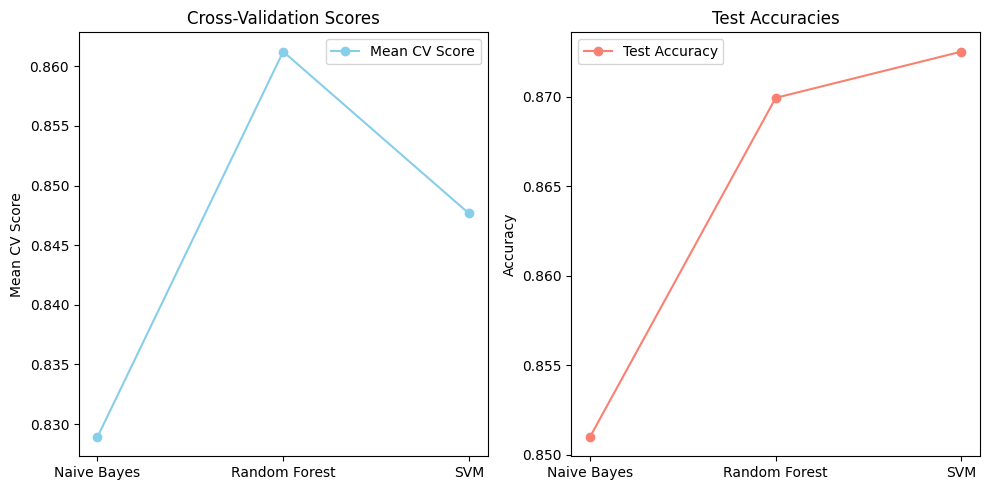

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os
import json
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

data = []
labels = []

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    for file_name in os.listdir(rumour_path):
        with open(os.path.join(rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)

    for file_name in os.listdir(non_rumour_path):
        with open(os.path.join(non_rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)

df = pd.DataFrame({'Text': data, 'Label': labels})

if 'Text' not in df.columns:
    print("The 'Text' column does not exist in the DataFrame.")
    raise KeyError("Column 'Text' not found.")

if df.empty:
    print("DataFrame is empty. Please check the loaded data.")
    raise ValueError("DataFrame is empty.")

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_vectorized, y_train)

svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train_vectorized, y_train)

nb_cv_scores = cross_val_score(nb_classifier, X_train_vectorized, y_train, cv=5)
rf_cv_scores = cross_val_score(rf_classifier, X_train_vectorized, y_train, cv=5)
svm_cv_scores = cross_val_score(svm_classifier, X_train_vectorized, y_train, cv=5)

nb_test_accuracy = accuracy_score(y_test, nb_classifier.predict(X_test_vectorized))
rf_test_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test_vectorized))
svm_test_accuracy = accuracy_score(y_test, svm_classifier.predict(X_test_vectorized))

models = ['Naive Bayes', 'Random Forest', 'SVM']
cv_scores = [nb_cv_scores.mean(), rf_cv_scores.mean(), svm_cv_scores.mean()]
test_accuracies = [nb_test_accuracy, rf_test_accuracy, svm_test_accuracy]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(models, cv_scores, marker='o', color='skyblue', label='Mean CV Score')
plt.title('Cross-Validation Scores')
plt.ylabel('Mean CV Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(models, test_accuracies, marker='o', color='salmon', label='Test Accuracy')
plt.title('Test Accuracies')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


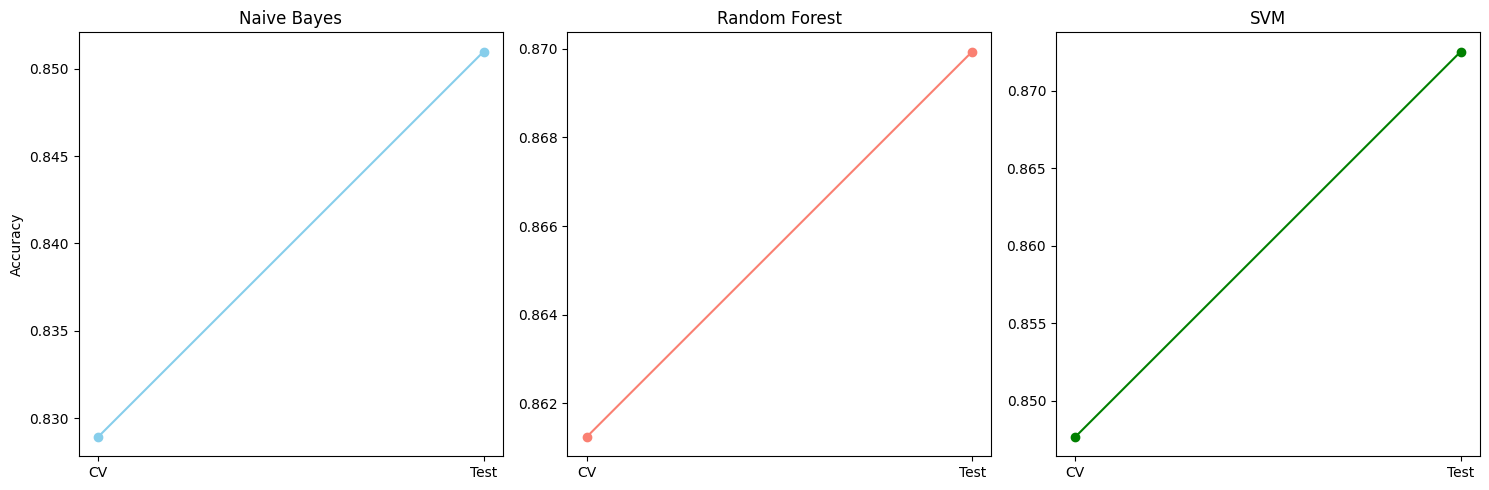

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os
import json
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

data = []
labels = []

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    for file_name in os.listdir(rumour_path):
        with open(os.path.join(rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)
    for file_name in os.listdir(non_rumour_path):
        with open(os.path.join(non_rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)
df = pd.DataFrame({'Text': data, 'Label': labels})

if 'Text' not in df.columns:
    print("The 'Text' column does not exist in the DataFrame.")
    raise KeyError("Column 'Text' not found.")

if df.empty:
    print("DataFrame is empty. Please check the loaded data.")
    raise ValueError("DataFrame is empty.")

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_vectorized, y_train)

svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train_vectorized, y_train)

nb_cv_scores = cross_val_score(nb_classifier, X_train_vectorized, y_train, cv=5)
rf_cv_scores = cross_val_score(rf_classifier, X_train_vectorized, y_train, cv=5)
svm_cv_scores = cross_val_score(svm_classifier, X_train_vectorized, y_train, cv=5)

nb_test_accuracy = accuracy_score(y_test, nb_classifier.predict(X_test_vectorized))
rf_test_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test_vectorized))
svm_test_accuracy = accuracy_score(y_test, svm_classifier.predict(X_test_vectorized))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(['CV', 'Test'], [nb_cv_scores.mean(), nb_test_accuracy], marker='o', color='skyblue')
plt.title('Naive Bayes')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(['CV', 'Test'], [rf_cv_scores.mean(), rf_test_accuracy], marker='o', color='salmon')
plt.title('Random Forest')

plt.subplot(1, 3, 3)
plt.plot(['CV', 'Test'], [svm_cv_scores.mean(), svm_test_accuracy], marker='o', color='green')
plt.title('SVM')

plt.tight_layout()
plt.show()


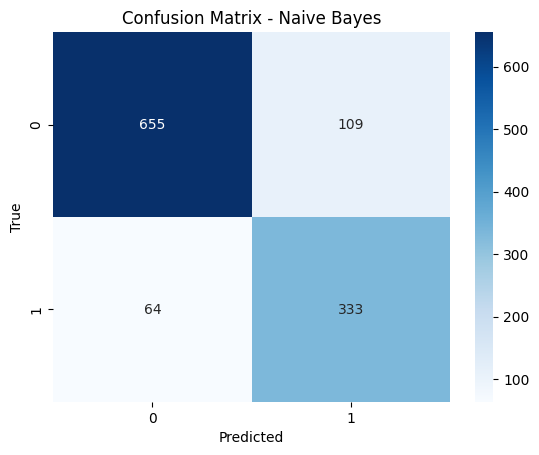

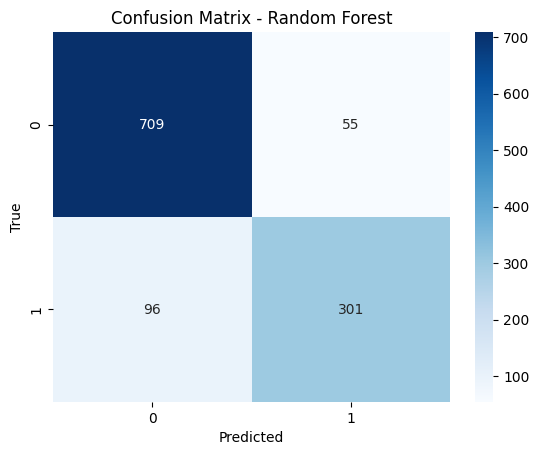

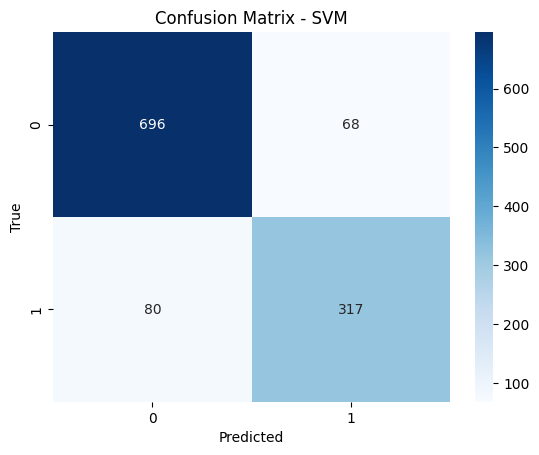

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def generate_confusion_matrix(y_true, y_pred, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.show()

rumour_dirs = ["charliehebdo", "ferguson", "germanwings-crash", "ottawashooting", "sydneysiege"]

data = []
labels = []

for rumour_dir in rumour_dirs:
    rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "rumours")
    non_rumour_path = os.path.join("/content/dataset/pheme-rnr-dataset", rumour_dir, "non-rumours")

    for file_name in os.listdir(rumour_path):
        with open(os.path.join(rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(1)
    for file_name in os.listdir(non_rumour_path):
        with open(os.path.join(non_rumour_path, file_name, "source-tweet", file_name + ".json"), 'r') as f:
            tweet = json.load(f)
            data.append(preprocess_text(tweet['text']))
            labels.append(0)
df = pd.DataFrame({'Text': data, 'Label': labels})

if 'Text' not in df.columns:
    print("The 'Text' column does not exist in the DataFrame.")
    raise KeyError("Column 'Text' not found.")

if df.empty:
    print("DataFrame is empty. Please check the loaded data.")
    raise ValueError("DataFrame is empty.")

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_vectorized, y_train)

svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train_vectorized, y_train)

y_pred_nb = nb_classifier.predict(X_test_vectorized)
y_pred_rf = rf_classifier.predict(X_test_vectorized)
y_pred_svm = svm_classifier.predict(X_test_vectorized)

generate_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

generate_confusion_matrix(y_test, y_pred_rf, "Random Forest")

generate_confusion_matrix(y_test, y_pred_svm, "SVM")
